In [1]:
# import libraries

import numpy as np
from astropy.io import fits
from photutils import datasets
import matplotlib.pyplot as plt
from photutils import find_peaks
from photutils import DAOStarFinder
from photutils import IRAFStarFinder
from photutils import CircularAperture
from astropy.stats import sigma_clipped_stats
from astropy.visualization import simple_norm
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [2]:
# The following code shows how we can open a FITS file and print out its header information:

hdulist = fits.open('./dataset2/g_prime/CCDC-LIGHT-20210110233126.fits')
hdulist.info()

Filename: ./dataset2/g_prime/CCDC-LIGHT-20210110233126.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (3352, 2532)   int16 (rescales to uint16)   


In [3]:
data = hdulist[0].data[0:400,0:400]

In [4]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
print((mean, median, std))

(3092.833431571311, 3092.0, 87.29413755065907)


In [5]:
#Now we will subtract the background and use an instance of DAOStarFinder 
#to find the stars in the image that have FWHMs of around 3 pixels and have
#peaks approximately 5-sigma above the background. Running this class 
#on the data yields an astropy Table containing the results of the star finder:

# DAOStarFinder is a class that provides an implementation of the DAOFIND algorithm 
# (Stetson 1987, PASP 99, 191). It searches images for local density maxima that have a peak 
# amplitude greater than a specified threshold (the threshold is applied to a convolved image)
# and have a size and shape similar to a defined 2D Gaussian kernel. DAOStarFinder also 
# provides an estimate of the objects’ roundness and sharpness, whose lower and upper bounds
# can be specified.

#IRAFStarFinder is a class that implements IRAF’s starfind algorithm. It is fundamentally 
# similar to DAOStarFinder, but DAOStarFinder can use an elliptical Gaussian kernel. 
# One other difference in IRAFStarFinder is that it calculates the objects’ centroid,
# roundness, and sharpness using image moments.

iraffind = IRAFStarFinder(fwhm=3.0, threshold=5.*std)  
sources_iraf = iraffind(data - median)  

for col in sources_iraf.colnames:  
    sources_iraf[col].info.format = '%.8g'  # for consistent table output    
    

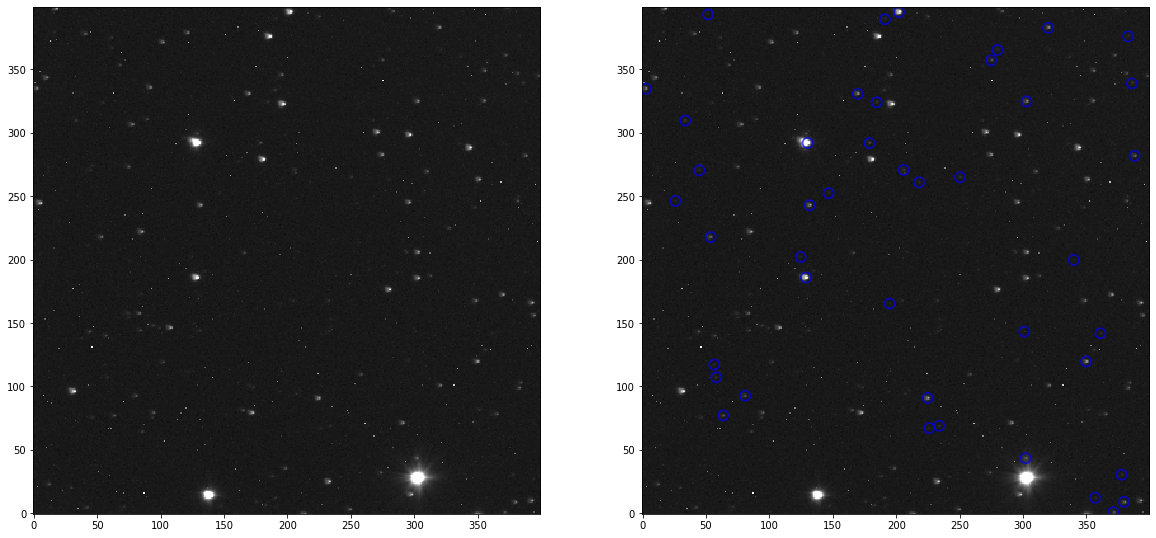

In [7]:
#visualizing
positions_iraf = np.transpose((sources_iraf['xcentroid'], sources_iraf['ycentroid']))
apertures_iraf = CircularAperture(positions_iraf, r=4.)
norm = ImageNormalize(stretch=SqrtStretch())

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(data, cmap='Greys_r', origin='lower', norm=norm, interpolation='nearest')

apertures_iraf.plot(color='blue', lw=1.7, alpha=0.7)
axs[1].imshow(data, norm=norm, origin='lower', cmap='Greys_r', interpolation='nearest')